In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import math
import time

# --- 1. TicTacToe 게임 환경 (이전과 동일) ---
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        return self.board.flatten()

    def get_available_actions(self):
        return [i for i, val in enumerate(self.get_state()) if val == 0]

    def make_move(self, action):
        if self.get_state()[action] != 0:
            raise ValueError("Invalid move")
        row, col = action // 3, action % 3
        self.board[row, col] = self.current_player
        winner = self.check_winner()
        done = winner is not None
        reward = 0
        if done:
            if winner == 1: reward = 1
            elif winner == -1: reward = -1
            else: reward = 0
        self.current_player *= -1
        return self.get_state(), reward, done

    def check_winner(self):
        for i in range(3):
            if abs(self.board[i, :].sum()) == 3: return self.board[i, 0]
            if abs(self.board[:, i].sum()) == 3: return self.board[0, i]
        if abs(np.diag(self.board).sum()) == 3: return self.board[0, 0]
        if abs(np.diag(np.fliplr(self.board)).sum()) == 3: return self.board[0, 2]
        if not np.any(self.board == 0): return 0
        return None

# --- 2. 최적화된 데이터 생성 ---

# Minimax 알고리즘 (이전과 동일)
def minimax(board, player):
    game = TicTacToe()
    game.board = board
    winner = game.check_winner()
    if winner is not None:
        return winner * player
    best_score = -math.inf
    for action in game.get_available_actions():
        new_board = board.copy()
        row, col = action // 3, action % 3
        new_board[row, col] = player
        score = -minimax(new_board, -player)
        if score > best_score: best_score = score
    return best_score if best_score != -math.inf else 0

def get_canonical_form(board):
    """보드의 8가지 대칭(회전, 대칭) 중 정규형(canonical form)을 찾습니다."""
    symmetries = []
    current_board = board.copy()
    for _ in range(4): # 4 rotations
        symmetries.append(current_board)
        symmetries.append(np.fliplr(current_board))
        current_board = np.rot90(current_board)

    # 튜플로 변환하여 정렬 가능하게 만듦
    symmetries_as_tuples = [tuple(b.flatten()) for b in symmetries]
    canonical_tuple = min(symmetries_as_tuples)
    return np.array(canonical_tuple).reshape(3, 3)

memoized_policy = {}
def build_optimal_policy_map(board, player):
    """모든 고유 상태에 대한 최적의 수를 미리 계산하여 맵에 저장 (재귀)"""
    canonical_board = get_canonical_form(board)
    canonical_tuple = tuple(canonical_board.flatten())

    if canonical_tuple in memoized_policy or TicTacToe()._check_winner_on_board(board) is not None:
        return

    game = TicTacToe()
    game.board = board
    available_actions = game.get_available_actions()
    
    best_score = -math.inf
    best_moves = []
    
    for action in available_actions:
        new_board = board.copy()
        row, col = action // 3, action % 3
        new_board[row, col] = player
        score = -minimax(new_board, -player)
        
        if score > best_score:
            best_score = score
            best_moves = [action]
        elif score == best_score:
            best_moves.append(action)

    memoized_policy[tuple(board.flatten())] = best_moves
    
    for move in best_moves:
        next_board = board.copy()
        row, col = move // 3, move % 3
        next_board[row, col] = player
        build_optimal_policy_map(next_board, -player)

# TicTacToe 클래스 내부에 헬퍼 함수 추가
TicTacToe._check_winner_on_board = lambda self, board: TicTacToe.check_winner(type('obj', (object,), {'board': board})())


def generate_all_optimal_trajectories():
    """사전 계산된 정책을 사용하여 모든 최적의 경로를 생성합니다."""
    print("Pre-calculating optimal policy for all unique states...")
    start_board = np.zeros((3, 3), dtype=int)
    build_optimal_policy_map(start_board, 1)
    
    print("Generating all unique optimal trajectories...")
    all_trajectories = []
    
    def find_paths(board, player, path):
        winner = TicTacToe()._check_winner_on_board(board)
        if winner is not None:
            states, actions = zip(*path) if path else ([], [])
            rewards = np.zeros(len(actions))
            
            # 승패에 따라 Reward-to-go 계산
            rewards_to_go = np.zeros_like(rewards, dtype=float)
            final_reward = winner # 1 for win, -1 for loss, 0 for draw
            for t in range(len(rewards)):
                rewards_to_go[t] = final_reward
                
            all_trajectories.append({
                'states': np.array(states),
                'actions': np.array(actions),
                'rewards_to_go': rewards_to_go
            })
            return

        optimal_moves = memoized_policy.get(tuple(board.flatten()))
        if not optimal_moves: return

        for move in optimal_moves:
            next_board = board.copy()
            row, col = move // 3, move % 3
            next_board[row, col] = player
            find_paths(next_board, -player, path + [(board.flatten(), move)])

    find_paths(start_board, 1, [])
    return all_trajectories


# --- 3. PyTorch Dataset & Decision Transformer 모델 (이전과 동일) ---
class TicTacToeDataset(Dataset):
    def __init__(self, trajectories, context_length):
        self.trajectories = trajectories
        self.context_length = context_length

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = len(traj['states'])
        start_idx = random.randint(0, traj_len - 1)
        states = traj['states'][start_idx : start_idx + self.context_length]
        actions = traj['actions'][start_idx : start_idx + self.context_length]
        rtgs = traj['rewards_to_go'][start_idx : start_idx + self.context_length]
        T = len(states)
        padding_len = self.context_length - T
        states = torch.tensor(np.pad(states, ((0, padding_len), (0, 0)), 'constant'), dtype=torch.float32)
        actions = torch.tensor(np.pad(actions, (0, padding_len), 'constant', constant_values=-1), dtype=torch.long)
        rtgs = torch.tensor(np.pad(rtgs, (0, padding_len), 'constant'), dtype=torch.float32).unsqueeze(1)
        mask = torch.cat([torch.ones(T), torch.zeros(padding_len)], dim=0)
        return states, actions, rtgs, mask

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, action_dim, n_head, n_layer, d_model, context_length):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.embed_state = nn.Linear(state_dim, d_model)
        self.embed_action = nn.Embedding(action_dim + 1, d_model)
        self.embed_rtg = nn.Linear(1, d_model)
        self.embed_timestep = nn.Embedding(context_length, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layer)
        self.predict_action = nn.Linear(d_model, action_dim)

    def forward(self, states, actions, rtgs, timesteps):
        action_embeddings = self.embed_action(actions + 1)
        state_embeddings = self.embed_state(states)
        rtg_embeddings = self.embed_rtg(rtgs)
        time_embeddings = self.embed_timestep(timesteps)
        state_embeddings += time_embeddings
        action_embeddings += time_embeddings
        rtg_embeddings += time_embeddings
        stacked_inputs = torch.stack(
            (rtg_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(states.shape[0], 3 * self.context_length, self.d_model)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(3 * self.context_length).to(states.device)
        encoder_output = self.transformer_encoder(stacked_inputs, mask=causal_mask)
        x = encoder_output[:, 1::3, :]
        action_preds = self.predict_action(x)
        return action_preds

# --- 4. 학습 및 평가 (하이퍼파라미터 조정) ---
def train():
    # Hyperparameters (조정됨)
    CONTEXT_LENGTH = 9  # 최대 9수면 게임이 끝나므로
    N_EPOCHS = 30       # 데이터가 고품질이므로 에포크 감소
    BATCH_SIZE = 64     # 데이터셋 크기에 맞춰 배치 사이즈 조정
    LR = 1e-4
    D_MODEL = 128
    N_HEAD = 4
    N_LAYER = 3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    start_time = time.time()
    trajectories = generate_all_optimal_trajectories()
    end_time = time.time()
    print(f"Generated {len(trajectories)} unique optimal trajectories in {end_time - start_time:.2f} seconds.")
    
    dataset = TicTacToeDataset(trajectories, context_length=CONTEXT_LENGTH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = DecisionTransformer(
        state_dim=9, action_dim=9, n_head=N_HEAD, n_layer=N_LAYER,
        d_model=D_MODEL, context_length=CONTEXT_LENGTH
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    print("Starting training...")
    for epoch in range(N_EPOCHS):
        model.train()
        total_loss = 0
        for states, actions, rtgs, mask in dataloader:
            states, actions, rtgs, mask = states.to(device), actions.to(device), rtgs.to(device), mask.to(device)
            timesteps = torch.arange(CONTEXT_LENGTH, device=device).repeat(states.shape[0], 1)
            action_preds = model(states, actions, rtgs, timesteps)
            action_preds = action_preds.reshape(-1, 9)
            actions_target = actions.reshape(-1)
            mask = mask.reshape(-1).bool()
            action_preds = action_preds[mask]
            actions_target = actions_target[mask]
            valid_targets = actions_target != -1
            loss = loss_fn(action_preds[valid_targets], actions_target[valid_targets])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{N_EPOCHS}, Loss: {avg_loss:.4f}")
        
    print("Training finished.")
    return model

def play_game_with_model(model, context_length):
    model.eval()
    
    # 모델이 현재 사용 중인 device를 가져옵니다.
    device = next(model.parameters()).device
    
    env = TicTacToe()
    
    # 모든 텐서를 생성할 때 .to(device)를 붙여줍니다.
    states = torch.zeros((1, context_length, 9), dtype=torch.float32, device=device)
    actions = torch.full((1, context_length), -1, dtype=torch.long, device=device)
    rtgs = torch.zeros((1, context_length, 1), dtype=torch.float32, device=device)
    rtgs[0, :, 0] = 1.0 # 목표는 승리(RTG=1)
    timesteps = torch.arange(0, context_length, device=device).unsqueeze(0)

    print("\n--- New Game: You are 'O' ---")
    turn = 0
    done = False
    
    while not done and turn < 9:
        board_str = ""
        for i, cell in enumerate(env.get_state()):
            mark = 'X' if cell == 1 else 'O' if cell == -1 else str(i)
            board_str += f" {mark} "
            if (i+1) % 3 == 0:
                board_str += "\n" if i < 8 else ""
                if i < 8: board_str += "---+---+---\n"
        print(board_str)

        if env.current_player == 1:
            print("Model's turn ('X')...")
            with torch.no_grad():
                # 이제 모델과 입력 텐서가 모두 같은 device에 있습니다.
                pred_actions = model(states, actions, rtgs, timesteps)
            logits = pred_actions[0, turn, :]
            available_actions = env.get_available_actions()
            mask = torch.full_like(logits, -float('inf'))
            mask[available_actions] = 0
            move = (logits + mask).argmax().item()
            print(f"Model chooses action: {move}")
        else:
            try:
                move = int(input("Your turn ('O'). Enter move (0-8): "))
                if move not in env.get_available_actions():
                    print("Invalid move. Try again.")
                    continue
            except (ValueError, IndexError):
                print("Invalid input. Enter a number between 0 and 8.")
                continue

        # 상태 업데이트 시에도 .to(device)가 필요합니다.
        if turn < context_length:
            current_state_tensor = torch.tensor(env.get_state(), dtype=torch.float32).to(device)
            states[0, turn] = current_state_tensor
            actions[0, turn] = move
        
        _, reward, done = env.make_move(move)
        
        # RTG 업데이트
        if turn + 1 < context_length:
            rtgs[0, turn+1:] = rtgs[0, turn:-1].clone() # clone()을 사용하여 인플레이스 수정 방지
            rtgs[0, turn, 0] -= reward
        
        turn += 1
        print("-" * 20)

    winner = env.check_winner()
    print("--- Game Over ---")
    if winner == 1: print("Model (X) wins!")
    elif winner == -1: print("You (O) win!")
    else: print("It's a draw!")




In [13]:
# --- 아래 함수를 코드에 추가하세요 ---

def test_minimax_evaluation():
    """
    특정 보드 상태에서 minimax 함수가 각 가능한 수의 가치를 어떻게 평가하는지 보여줍니다.
    """
    print("\n--- Minimax Evaluation Test ---")

    # 테스트할 보드 상태를 설정합니다. (X: 1, O: -1, 빈칸: 0)
    # 예시: X가 중앙(4)에, O가 좌상단(0)에 둔 상태
    #  O |   |
    # ---+---+---
    #    | X |
    # ---+---+---
    #    |   |
    test_board = np.array([
        [-1, -1, 0],
        [ 1, 1, -1],
        [ -1, -1, 1]
    ], dtype=int)

    # 현재 플레이어는 X (1)
    current_player = 1

    game = TicTacToe()
    game.board = test_board
    game.current_player = current_player

    print("Current Board State:")
    board_str = ""
    for i, cell in enumerate(game.get_state()):
        mark = 'X' if cell == 1 else 'O' if cell == -1 else str(i)
        board_str += f" {mark} "
        if (i+1) % 3 == 0:
            board_str += "\n" if i < 8 else ""
            if i < 8: board_str += "---+---+---\n"
    print(board_str)
    print(f"Current Player: 'X' ({current_player})")
    print("-" * 20)

    available_actions = game.get_available_actions()
    print(f"Available actions: {available_actions}\n")

    move_scores = {}

    # 모든 가능한 수에 대해 minimax 점수를 계산
    for action in available_actions:
        # 가상의 다음 보드 생성
        next_board = test_board.copy()
        row, col = action // 3, action % 3
        next_board[row, col] = current_player

        # 다음 수는 상대방(-1) 차례이므로, 상대방 입장에서의 점수를 계산
        # 그 점수에 -를 붙이면 현재 플레이어 입장에서의 점수가 됨
        score = -minimax(next_board, -current_player)
        move_scores[action] = score

    print("Minimax score for each possible move:")
    for move, score in move_scores.items():
        result = ""
        if score == 1:
            result = "-> Guaranteed Win"
        elif score == 0:
            result = "-> Leads to a Draw"
        elif score == -1:
            result = "-> Leads to a Loss"
        print(f" - Placing 'X' at position {move}: Score = {score} {result}")

    best_score = max(move_scores.values())
    optimal_moves = [move for move, score in move_scores.items() if score == best_score]

    print("\n" + "="*30)
    print(f"Conclusion:")
    print(f"The best possible outcome for 'X' from this state is a score of {best_score}.")
    print(f"Optimal move(s) for 'X' are: {optimal_moves}")
    print("="*30)


# --- 메인 실행 부분 수정 ---
if __name__ == "__main__":
    # Minimax 함수 테스트 실행
    test_minimax_evaluation()

    # Decision Transformer 모델 학습 및 실행 (원할 경우 주석 해제)
    # model = train()
    # play_game_with_model(model, CONTEXT_LENGTH)


--- Minimax Evaluation Test ---
Current Board State:
 O  O  2 
---+---+---
 X  X  O 
---+---+---
 O  O  X 
Current Player: 'X' (1)
--------------------
Available actions: [2]

Minimax score for each possible move:
 - Placing 'X' at position 2: Score = 0 -> Leads to a Draw

Conclusion:
The best possible outcome for 'X' from this state is a score of 0.
Optimal move(s) for 'X' are: [2]


In [14]:
# --- 아래 새로운 함수를 기존 코드에 추가하세요 ---

def analyze_move_reason(board, action, player):
    """
    주어진 보드(board)에서 플레이어(player)가 특정 수(action)를 두는 것의
    전략적 이유를 분석하여 문자열로 반환합니다.
    """
    # 1. 가상의 다음 보드 생성
    next_board = board.copy()
    row, col = action // 3, action % 3
    next_board[row, col] = player

    # --- 패턴 1: 즉시 승리하는 수인지 확인 ---
    game = TicTacToe()
    game.board = next_board
    if game.check_winner() == player:
        return "[승리] 이 수로 한 줄을 완성하여 즉시 승리합니다."

    # --- 패턴 2: 상대방의 승리를 막는 필수 방어 수인지 확인 ---
    # 내가 두려는 그 자리에 만약 상대방이 두었다면 상대가 이기는 상황이었는지 확인
    opponent_board = board.copy()
    opponent_board[row, col] = -player # 상대방이 두었다고 가정
    game.board = opponent_board
    if game.check_winner() == -player:
        return "[필수 방어] 상대방이 다음 수에 이기는 것을 막는 결정적인 수입니다."

    # --- 패턴 3 & 4: 공격적인 수(위협, 포크)인지 확인 ---
    # 내가 둔 이후의 보드(next_board)에서, 나의 돌 2개 + 빈칸 1개 라인이 몇 개인지 계산
    threat_lines = 0
    win_patterns = [
        # Rows
        [0, 1, 2], [3, 4, 5], [6, 7, 8],
        # Columns
        [0, 3, 6], [1, 4, 7], [2, 5, 8],
        # Diagonals
        [0, 4, 8], [2, 4, 6]
    ]
    flat_next_board = next_board.flatten()
    for pattern in win_patterns:
        line = [flat_next_board[i] for i in pattern]
        if line.count(player) == 2 and line.count(0) == 1:
            threat_lines += 1

    if threat_lines >= 2:
        return "[공격: 포크 생성] 두 개 이상의 공격 라인을 동시에 만들어 필승 전략을 구축합니다."
    if threat_lines == 1:
        return "[공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다."

    # --- 기타: 위의 특정 패턴에 해당하지 않는 경우 ---
    return "[전략적 수] 장기적으로 유리한 위치를 점하기 위한 수입니다 (Minimax 평가)."


# --- 기존의 test_minimax_evaluation 함수를 아래와 같이 수정하세요 ---

def test_minimax_evaluation():
    """
    특정 보드 상태에서 minimax 함수가 각 가능한 수의 가치를 어떻게 평가하고,
    그 이유가 무엇인지 함께 보여줍니다.
    """
    print("\n--- Minimax & Reason Analysis Test ---")

    # 테스트할 보드 상태 (X가 중앙, O가 좌상단)
    test_board = np.array([
        [-1, 0, 0],
        [ 0, 1, 0],
        [ 0, 0, 0]
    ], dtype=int)
    current_player = 1

    game = TicTacToe()
    game.board = test_board
    game.current_player = current_player

    # (이하 보드 출력 코드는 이전과 동일)
    print("Current Board State:")
    board_str = ""
    for i, cell in enumerate(game.get_state()):
        mark = 'X' if cell == 1 else 'O' if cell == -1 else str(i)
        board_str += f" {mark} "
        if (i+1) % 3 == 0:
            board_str += "\n" if i < 8 else ""
            if i < 8: board_str += "---+---+---\n"
    print(board_str)
    print(f"Current Player: 'X' ({current_player})")
    print("-" * 30)

    available_actions = game.get_available_actions()
    move_evaluations = {}

    for action in available_actions:
        score = -minimax(game.board, -current_player)
        # 각 수에 대한 이유 분석 추가
        reason = analyze_move_reason(game.board, action, current_player)
        move_evaluations[action] = {'score': score, 'reason': reason}

    print("Evaluation for each possible move:")
    # 점수가 높은 순으로 정렬하여 출력
    sorted_moves = sorted(move_evaluations.items(), key=lambda item: item[1]['score'], reverse=True)

    for move, eval_data in sorted_moves:
        score = eval_data['score']
        reason = eval_data['reason']
        print(f" - Move to {move}: Score = {score:2d} | Reason: {reason}")

    best_score = sorted_moves[0][1]['score']
    optimal_moves = [move for move, eval_data in sorted_moves if eval_data['score'] == best_score]

    print("\n" + "="*40)
    print(f"Conclusion:")
    print(f"Optimal move(s) for 'X' are: {optimal_moves} (Score: {best_score})")
    print(f"The primary reason for choosing these moves is their potential to create threats or forks.")
    print("="*40)

# 메인 실행 부분에 test_minimax_evaluation() 호출을 넣어두세요.
if __name__ == "__main__":
    test_minimax_evaluation()


--- Minimax & Reason Analysis Test ---
Current Board State:
 O  1  2 
---+---+---
 3  X  5 
---+---+---
 6  7  8 
Current Player: 'X' (1)
------------------------------
Evaluation for each possible move:
 - Move to 1: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 2: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 3: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 5: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 6: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 7: Score =  0 | Reason: [공격: 위협 생성] 다음 턴에 이길 수 있는 공격 라인(돌 2개)을 만듭니다.
 - Move to 8: Score =  0 | Reason: [전략적 수] 장기적으로 유리한 위치를 점하기 위한 수입니다 (Minimax 평가).

Conclusion:
Optimal move(s) for 'X' are: [1, 2, 3, 5, 6, 7, 8] (Score: 0)
The primary reason for choosing these moves is their potential to create threats or forks.


In [6]:
if __name__ == '__main__':
    CONTEXT_LENGTH = 9
    trained_model = train()
    while True:
        play_game_with_model(trained_model, CONTEXT_LENGTH)
        if input("Play again? (y/n): ").lower() != 'y':
            break

Using device: cpu
Pre-calculating optimal policy for all unique states...
Generating all unique optimal trajectories...
Generated 1023 unique optimal trajectories in 16.06 seconds.
Starting training...
Epoch 1/30, Loss: 2.1628
Epoch 2/30, Loss: 2.0643
Epoch 3/30, Loss: 1.9734
Epoch 4/30, Loss: 1.8626
Epoch 5/30, Loss: 1.7800
Epoch 6/30, Loss: 1.6643
Epoch 7/30, Loss: 1.5774
Epoch 8/30, Loss: 1.4872
Epoch 9/30, Loss: 1.4239
Epoch 10/30, Loss: 1.3650
Epoch 11/30, Loss: 1.3158
Epoch 12/30, Loss: 1.2815
Epoch 13/30, Loss: 1.2238
Epoch 14/30, Loss: 1.1745
Epoch 15/30, Loss: 1.1447
Epoch 16/30, Loss: 1.1104
Epoch 17/30, Loss: 1.0781
Epoch 18/30, Loss: 1.0413
Epoch 19/30, Loss: 1.0136
Epoch 20/30, Loss: 0.9785
Epoch 21/30, Loss: 0.9699
Epoch 22/30, Loss: 0.9621
Epoch 23/30, Loss: 0.9377
Epoch 24/30, Loss: 0.9214
Epoch 25/30, Loss: 0.9025
Epoch 26/30, Loss: 0.8833
Epoch 27/30, Loss: 0.8705
Epoch 28/30, Loss: 0.8685
Epoch 29/30, Loss: 0.8503
Epoch 30/30, Loss: 0.8534
Training finished.

--- New

In [6]:
trained_model

DecisionTransformer(
  (embed_state): Linear(in_features=9, out_features=128, bias=True)
  (embed_action): Embedding(10, 128)
  (embed_rtg): Linear(in_features=1, out_features=128, bias=True)
  (embed_timestep): Embedding(9, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predict_action): Linear(in_features=128, out_fea

In [7]:
import torch.nn.functional as F

def analyze_model_decision(model, board_state, context_length=9):
    """
    주어진 보드 상태에서 모델이 각 행동에 대해 어떻게 평가하는지 분석합니다.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 모델 입력을 위한 빈 시퀀스 준비
    states = torch.zeros((1, context_length, 9), dtype=torch.float32, device=device)
    actions = torch.full((1, context_length), -1, dtype=torch.long, device=device)
    rtgs = torch.zeros((1, context_length, 1), dtype=torch.float32, device=device)
    rtgs[0, :, 0] = 1.0  # 항상 '승리'를 목표로 결정 분석
    timesteps = torch.arange(0, context_length, device=device).unsqueeze(0)

    # 현재 상태를 시퀀스의 첫 번째(turn=0)에 배치
    states[0, 0] = torch.tensor(board_state, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        pred_actions_logits = model(states, actions, rtgs, timesteps)
        
    # 첫 번째 턴에 대한 결정(logits)을 가져옴
    logits = pred_actions_logits[0, 0, :]
    
    # Softmax를 이용해 확률로 변환
    probabilities = F.softmax(logits, dim=0)
    
    print("===== Model Decision Analysis =====")
    print("Board State (1: Model, -1: Opponent):", board_state)
    print("\nAction Probabilities:")
    
    # 가능한 수와 불가능한 수 구분하여 출력
    available_actions = [i for i, val in enumerate(board_state) if val == 0]
    for i, prob in enumerate(probabilities):
        move_type = "Legal" if i in available_actions else "Illegal"
        print(f"  Move {i}: {prob.item():.4f} ({prob.item()*100:.2f}%) [{move_type}]")
        
    best_move = probabilities.argmax().item()
    print(f"\n=> Model's Best Choice: Move {best_move} ({probabilities[best_move].item()*100:.2f}%)")
    print("===================================\n")
    return probabilities

# trained_model이 학습 완료된 모델이라고 가정
# 예제 분석 실행
# 1. 빈 보드 (첫 수 분석)
empty_board = [0, 0, 0, 0, 0, 0, 0, 0, 0]
analyze_model_decision(trained_model, empty_board)

# 2. 상대방(O)이 2개를 놓아 반드시 막아야 하는 상황
must_block_board = [ -1, -1, 0,  # O, O, _
                      0, 1, 0, 
                      0, 0, 0]
analyze_model_decision(trained_model, must_block_board)

# 3. 내가(X) 2개를 놓아 바로 이길 수 있는 상황
can_win_board = [ 1, 1, 0,  # X, X, _
                 -1, 0, 0, 
                 -1, 0, 0]
analyze_model_decision(trained_model, can_win_board)

===== Model Decision Analysis =====
Board State (1: Model, -1: Opponent): [0, 0, 0, 0, 0, 0, 0, 0, 0]

Action Probabilities:
  Move 0: 0.0799 (7.99%) [Legal]
  Move 1: 0.6264 (62.64%) [Legal]
  Move 2: 0.0046 (0.46%) [Legal]
  Move 3: 0.1470 (14.70%) [Legal]
  Move 4: 0.0363 (3.63%) [Legal]
  Move 5: 0.0314 (3.14%) [Legal]
  Move 6: 0.0161 (1.61%) [Legal]
  Move 7: 0.0049 (0.49%) [Legal]
  Move 8: 0.0533 (5.33%) [Legal]

=> Model's Best Choice: Move 1 (62.64%)

===== Model Decision Analysis =====
Board State (1: Model, -1: Opponent): [-1, -1, 0, 0, 1, 0, 0, 0, 0]

Action Probabilities:
  Move 0: 0.0204 (2.04%) [Illegal]
  Move 1: 0.4443 (44.43%) [Illegal]
  Move 2: 0.0428 (4.28%) [Legal]
  Move 3: 0.1606 (16.06%) [Legal]
  Move 4: 0.0007 (0.07%) [Illegal]
  Move 5: 0.0475 (4.75%) [Legal]
  Move 6: 0.0505 (5.05%) [Legal]
  Move 7: 0.0026 (0.26%) [Legal]
  Move 8: 0.2307 (23.07%) [Legal]

=> Model's Best Choice: Move 1 (44.43%)

===== Model Decision Analysis =====
Board State (1: Model, 

tensor([0.0175, 0.1842, 0.0290, 0.0449, 0.0891, 0.1057, 0.1907, 0.2156, 0.1234],
       device='cuda:0')

In [2]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 68.6 MB 381 kB/s eta 0:00:01     |████████████████▋               | 35.5 MB 4.2 MB/s eta 0:00:08
     |████████████████████████████████| 1.9 MB 84.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 74.1 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 72.1 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 72.4 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 72.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 4.8 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
def create_value_dataset():
    """
    모든 고유한 틱택토 상태와 그에 대한 minimax 가치를 포함하는 데이터셋을 생성합니다.
    """
    print("Generating all unique board states and their values...")
    q = [(np.zeros((3, 3), dtype=int), 1)] # (board, player)
    visited_states = set()
    dataset = []

    while q:
        board, player = q.pop(0)
        canonical_board = get_canonical_form(board)
        state_tuple = tuple(canonical_board.flatten())

        if state_tuple in visited_states:
            continue
        visited_states.add(state_tuple)

        game = TicTacToe()
        game.board = board
        winner = game.check_winner()

        # 플레이어 X(1) 기준의 가치를 계산
        value = minimax(board.copy(), 1)
        dataset.append((board, value))

        if winner is not None:
            continue

        for action in game.get_available_actions():
            next_board = board.copy()
            row, col = action // 3, action % 3
            next_board[row, col] = player
            q.append((next_board, -player))

    print(f"Generated {len(dataset)} unique states.")
    return dataset

In [16]:
class PatternCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력 채널 3개 (Empty, Player X, Player O)
        # 3x3 커널을 가진 16개의 필터(패턴 탐지기)를 사용
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 1)
        self.tanh = nn.Tanh() # 출력 값을 -1과 1 사이로 조정

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = x.view(-1, 32 * 3 * 3) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.tanh(x)

def board_to_tensor(board):
    """ 보드를 (3, 3, 3) 크기의 one-hot 인코딩 텐서로 변환 """
    tensor = np.zeros((3, 3, 3), dtype=np.float32)
    tensor[:, :, 0][board == 0] = 1 # Empty channel
    tensor[:, :, 1][board == 1] = 1 # Player X channel
    tensor[:, :, 2][board == -1] = 1 # Player O channel
    return torch.from_numpy(tensor).permute(2, 0, 1) # (C, H, W)

Generating all unique board states and their values...
Generated 765 unique states.

Training PatternCNN to learn board values...
Epoch 1, Loss: 0.357920
Epoch 2, Loss: 0.334862
Epoch 3, Loss: 0.303258
Epoch 4, Loss: 0.252961
Epoch 5, Loss: 0.216505
Epoch 6, Loss: 0.184901
Epoch 7, Loss: 0.162573
Epoch 8, Loss: 0.138026
Epoch 9, Loss: 0.118670
Epoch 10, Loss: 0.090382
Epoch 11, Loss: 0.075305
Epoch 12, Loss: 0.077598
Epoch 13, Loss: 0.066793
Epoch 14, Loss: 0.074251
Epoch 15, Loss: 0.068498
Epoch 16, Loss: 0.061013
Epoch 17, Loss: 0.047602
Epoch 18, Loss: 0.052531
Epoch 19, Loss: 0.054021
Epoch 20, Loss: 0.046804
Epoch 21, Loss: 0.042712
Epoch 22, Loss: 0.038698
Epoch 23, Loss: 0.039653
Epoch 24, Loss: 0.040130
Epoch 25, Loss: 0.042418
Epoch 26, Loss: 0.035718
Epoch 27, Loss: 0.033584
Epoch 28, Loss: 0.026998
Epoch 29, Loss: 0.028518
Epoch 30, Loss: 0.028198

--- Visualizing Learned Patterns ---


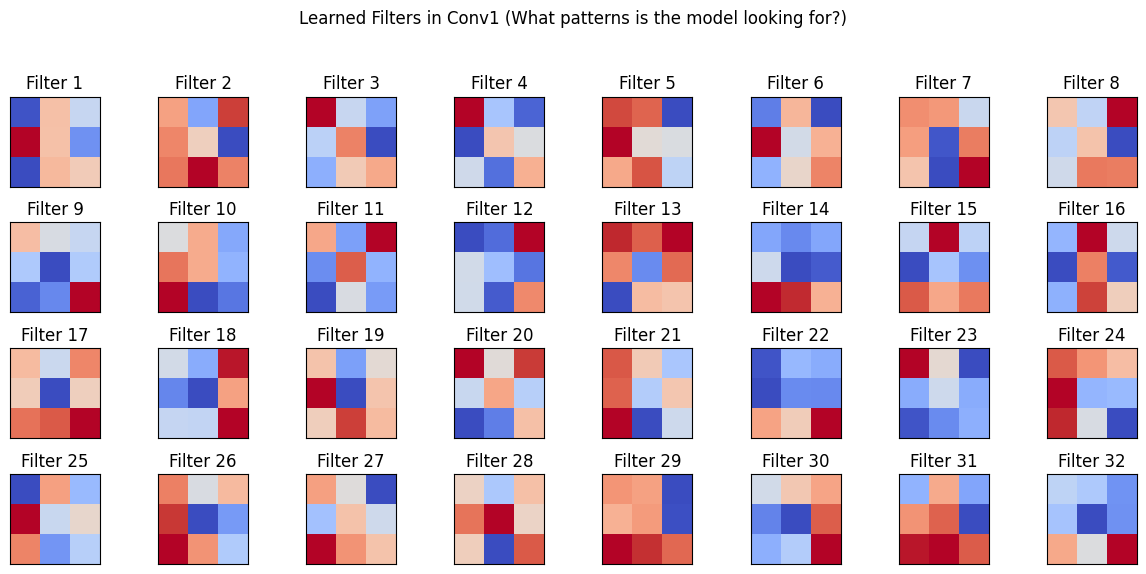

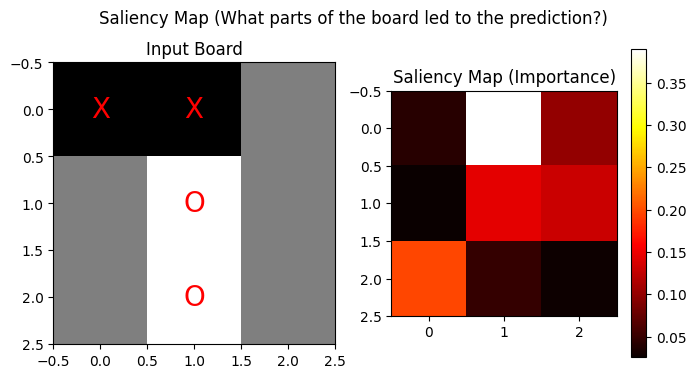

In [18]:
import matplotlib.pyplot as plt
import torch.optim as optim

def train_and_visualize_patterns():
    # 1. 데이터 생성
    value_dataset = create_value_dataset()
    
    # 2. 모델 및 옵티마이저 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PatternCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 3. 모델 학습
    print("\nTraining PatternCNN to learn board values...")
    for epoch in range(30): # 예시로 10 에포크만 학습
        total_loss = 0
        for board, value in value_dataset:
            board_tensor = board_to_tensor(board).unsqueeze(0).to(device)
            target_value = torch.tensor([[value]], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            prediction = model(board_tensor)
            loss = loss_fn(prediction, target_value)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(value_dataset):.6f}")

    # 4. 패턴 분석 및 시각화
    print("\n--- Visualizing Learned Patterns ---")
    
    # 방법 1: 학습된 필터 시각화
    filters = model.conv1.weight.detach().cpu()
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    fig.suptitle("Learned Filters in Conv1 (What patterns is the model looking for?)")
    for i, ax in enumerate(axes.flat):
        if i < 32:
            # Player X 채널에 대한 필터 가중치를 시각화
            f = filters[i, 1, :, :] # 0: Empty, 1: Player X, 2: Player O
            ax.imshow(f, cmap='coolwarm')
            ax.set_title(f'Filter {i+1}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 방법 2: Saliency Map 시각화
    # 예시: X가 두 개 있고, 한 칸만 채우면 이기는 보드
    test_board = np.array([[1, 1, 0], [0, -1, 0], [0, -1, 0]], dtype=int)
    board_tensor = board_to_tensor(test_board).unsqueeze(0).to(device)
    board_tensor.requires_grad = True # 그래디언트를 계산하기 위해 설정

    # 모델의 예측
    prediction = model(board_tensor)
    prediction.backward() # 예측값에 대한 입력의 그래디언트 계산

    # Saliency map 계산 및 시각화
    saliency, _ = torch.max(board_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Saliency Map (What parts of the board led to the prediction?)")
    ax1.set_title("Input Board")
    ax1.imshow(test_board, cmap='gray_r')
    for (j, i), label in np.ndenumerate(test_board):
        ax1.text(i, j, 'X' if label == 1 else 'O' if label == -1 else '', ha='center', va='center', color='red', fontsize=20)
    
    ax2.set_title("Saliency Map (Importance)")
    im = ax2.imshow(saliency, cmap='hot')
    plt.colorbar(im, ax=ax2)
    plt.show()

# 메인 실행 부분에 함수 호출
if __name__ == "__main__":
    train_and_visualize_patterns()

In [21]:
# (이전의 TicTacToe, get_canonical_form, minimax 등의 함수와 클래스는 그대로 둡니다)

def print_board(board):
    """
    3x3 numpy 배열 형태의 보드를 사람이 보기 좋게 출력합니다.
    """
    chars = {1: 'X', -1: 'O', 0: ' '}
    for i, row in enumerate(board):
        print(f" {chars[row[0]]} | {chars[row[1]]} | {chars[row[2]]} ")
        if i < 2:
            print("---+---+---")

def find_and_print_pre_win_states_for_x():
    """
    '한 수만 더 두면 X가 이기는' 모든 고유한 보드 상태를 찾아 출력합니다.
    """
    print("X의 '승리 직전' 상태인 모든 고유한 보드를 찾습니다...")

    # 1. 모든 가능한 고유 게임 상태 (보드, 현재 플레이어) 생성
    q = [(np.zeros((3, 3), dtype=int), 1)]  # (board, player) 큐
    visited_canonical_states = set()
    all_game_states = [] # (보드, 플레이어) 쌍을 저장할 리스트

    while q:
        board, player = q.pop(0)
        canonical_board_tuple = tuple(get_canonical_form(board).flatten())
        if canonical_board_tuple in visited_canonical_states:
            continue
        visited_canonical_states.add(canonical_board_tuple)
        all_game_states.append((board, player))
        
        game_instance = TicTacToe()
        game_instance.board = board
        if game_instance.check_winner() is None:
            for action in game_instance.get_available_actions():
                next_board = board.copy()
                row, col = action // 3, action % 3
                next_board[row, col] = player
                q.append((next_board, -player))

    print(f"\n총 {len(all_game_states)}개의 고유한 게임 상태를 생성했습니다.")
    print("이 중에서 X의 '승리 직전' 경우를 필터링하여 출력합니다.")

    # 2. 'X의 승리 직전' 보드만 필터링
    pre_win_boards = []
    for board, player in all_game_states:
        # 조건 1: 현재 X의 턴이어야 함 (X와 O의 돌 개수가 같음)
        if player != 1:
            continue

        game_instance.board = board
        # 조건 2: 아직 게임이 끝나지 않은 상태여야 함
        if game_instance.check_winner() is not None:
            continue
        
        # 조건 3: X가 즉시 이길 수 있는 수가 존재하는지 확인
        found_winning_move = False
        for action in game_instance.get_available_actions():
            temp_board = board.copy()
            row, col = action // 3, action % 3
            temp_board[row, col] = 1  # X를 놓아봄
            
            temp_game_instance = TicTacToe()
            temp_game_instance.board = temp_board
            if temp_game_instance.check_winner() == 1:
                found_winning_move = True
                break  # 이기는 수를 하나라도 찾았으면 더 볼 필요 없음
        
        if found_winning_move:
            pre_win_boards.append(board)

    print(f"\n찾았습니다! X의 '승리 직전' 고유한 보드 패턴은 총 {len(pre_win_boards)}개입니다.\n")

    # 3. 결과 출력
    for i, board in enumerate(pre_win_boards):
        print(f"--- 승리 직전 보드 #{i+1} ---")
        print_board(board)
        print("-" * 23 + "\n")


if __name__ == "__main__":
    # 위에서 정의한 함수를 실행합니다.
    find_and_print_pre_win_states_for_x()

X의 '승리 직전' 상태인 모든 고유한 보드를 찾습니다...

총 765개의 고유한 게임 상태를 생성했습니다.
이 중에서 X의 '승리 직전' 경우를 필터링하여 출력합니다.

찾았습니다! X의 '승리 직전' 고유한 보드 패턴은 총 207개입니다.

--- 승리 직전 보드 #1 ---
 X | O | O 
---+---+---
 X |   |   
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #2 ---
 X | O |   
---+---+---
 X | O |   
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #3 ---
 X | O |   
---+---+---
 X |   | O 
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #4 ---
 X | O |   
---+---+---
 X |   |   
---+---+---
   | O |   
-----------------------

--- 승리 직전 보드 #5 ---
 X | O |   
---+---+---
 X |   |   
---+---+---
   |   | O 
-----------------------

--- 승리 직전 보드 #6 ---
 X | O | O 
---+---+---
   | X |   
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #7 ---
 X | O |   
---+---+---
 O | X |   
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #8 ---
 X | O |   
---+---+---
   | X | O 
---+---+---
   |   |   
-----------------------

--- 승리 직전 보드 #9 ---
 X

In [22]:
# (이전의 TicTacToe, get_canonical_form, minimax 등의 함수와 클래스는 그대로 둡니다)

def print_board(board):
    """
    3x3 numpy 배열 형태의 보드를 사람이 보기 좋게 출력합니다.
    """
    chars = {1: 'X', -1: 'O', 0: ' '}
    for i, row in enumerate(board):
        print(f" {chars[row[0]]} | {chars[row[1]]} | {chars[row[2]]} ")
        if i < 2:
            print("---+---+---")

def get_pre_win_states_for_x():
    """
    '한 수만 더 두면 X가 이기는' 모든 고유한 보드 상태 리스트를 반환합니다.
    (이전 코드와 동일하지만, 출력이 아닌 리스트를 반환하도록 변경)
    """
    q = [(np.zeros((3, 3), dtype=int), 1)]
    visited_canonical_states = set()
    all_game_states = []
    while q:
        board, player = q.pop(0)
        canonical_board_tuple = tuple(get_canonical_form(board).flatten())
        if canonical_board_tuple in visited_canonical_states:
            continue
        visited_canonical_states.add(canonical_board_tuple)
        all_game_states.append((board, player))
        game_instance = TicTacToe()
        game_instance.board = board
        if game_instance.check_winner() is None:
            for action in game_instance.get_available_actions():
                next_board = board.copy()
                row, col = action // 3, action % 3
                next_board[row, col] = player
                q.append((next_board, -player))
    pre_win_boards = []
    for board, player in all_game_states:
        if player != 1: continue
        game_instance.board = board
        if game_instance.check_winner() is not None: continue
        found_winning_move = False
        for action in game_instance.get_available_actions():
            temp_board = board.copy()
            row, col = action // 3, action % 3
            temp_board[row, col] = 1
            temp_game_instance = TicTacToe()
            temp_game_instance.board = temp_board
            if temp_game_instance.check_winner() == 1:
                found_winning_move = True
                break
        if found_winning_move:
            pre_win_boards.append(board)
    return pre_win_boards

def find_winning_moves(board, player):
    """
    주어진 보드에서 플레이어가 즉시 이길 수 있는 모든 수를 찾습니다.
    """
    winning_moves = []
    game = TicTacToe()
    game.board = board
    for action in game.get_available_actions():
        temp_board = board.copy()
        row, col = action // 3, action % 3
        temp_board[row, col] = player
        
        temp_game = TicTacToe()
        temp_game.board = temp_board
        if temp_game.check_winner() == player:
            winning_moves.append(action)
    return winning_moves

def analyze_winning_configurations():
    """
    '승리 배치'들의 통계를 분석하고 각 위치별 돌의 빈도를 계산합니다.
    """
    print("X의 '승리 직전' 보드를 모두 생성합니다...")
    pre_win_boards = get_pre_win_states_for_x()
    print(f"총 {len(pre_win_boards)}개의 '승리 직전' 보드를 찾았습니다.")
    
    # 1. '승리 위치'를 기준으로 보드들을 그룹화
    grouped_by_win_spot = {i: [] for i in range(9)}
    for board in pre_win_boards:
        winning_moves = find_winning_moves(board, 1) # player 1 is X
        for move in winning_moves:
            grouped_by_win_spot[move].append(board)
            
    print("\n'승리 위치'별로 '승리 배치'들의 통계를 분석합니다...")
    
    # 2. 각 그룹별로 통계 분석
    for win_spot, boards in grouped_by_win_spot.items():
        print("\n" + "="*50)
        print(f"★★★ 승리 위치(Winning Spot): {win_spot} ★★★")
        print("="*50)
        
        total_boards = len(boards)
        if total_boards == 0:
            print("이 위치를 승리점으로 하는 '승리 직전' 상태가 없습니다.")
            continue
            
        print(f"이 위치를 통해 승리할 수 있는 '승리 배치'의 수: {total_boards}개")
        
        # 각 위치(0~8)별로 [Empty, X, O] 개수를 저장할 카운터
        position_counts = np.zeros((9, 3), dtype=int)

        for board in boards:
            flat_board = board.flatten()
            for pos in range(9):
                if flat_board[pos] == 0: position_counts[pos, 0] += 1
                elif flat_board[pos] == 1: position_counts[pos, 1] += 1
                elif flat_board[pos] == -1: position_counts[pos, 2] += 1
        
        print("\n'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:")
        print("-" * 50)
        # 3. 빈도 계산 및 출력
        for pos in range(9):
            if pos == win_spot: continue # 승리 위치는 분석에서 제외
            
            counts = position_counts[pos]
            freq_empty = (counts[0] / total_boards) * 100
            freq_x = (counts[1] / total_boards) * 100
            freq_o = (counts[2] / total_boards) * 100
            
            print(f"  - 위치 {pos}: \t빈칸({freq_empty:5.1f}%) \tX({freq_x:5.1f}%) \tO({freq_o:5.1f}%)")

if __name__ == "__main__":
    analyze_winning_configurations()

X의 '승리 직전' 보드를 모두 생성합니다...
총 207개의 '승리 직전' 보드를 찾았습니다.

'승리 위치'별로 '승리 배치'들의 통계를 분석합니다...

★★★ 승리 위치(Winning Spot): 0 ★★★
이 위치를 승리점으로 하는 '승리 직전' 상태가 없습니다.

★★★ 승리 위치(Winning Spot): 1 ★★★
이 위치를 통해 승리할 수 있는 '승리 배치'의 수: 2개

'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:
--------------------------------------------------
  - 위치 0: 	빈칸(  0.0%) 	X(100.0%) 	O(  0.0%)
  - 위치 2: 	빈칸(  0.0%) 	X( 50.0%) 	O( 50.0%)
  - 위치 3: 	빈칸(100.0%) 	X(  0.0%) 	O(  0.0%)
  - 위치 4: 	빈칸(  0.0%) 	X( 50.0%) 	O( 50.0%)
  - 위치 5: 	빈칸( 50.0%) 	X(  0.0%) 	O( 50.0%)
  - 위치 6: 	빈칸( 50.0%) 	X(  0.0%) 	O( 50.0%)
  - 위치 7: 	빈칸(  0.0%) 	X( 50.0%) 	O( 50.0%)
  - 위치 8: 	빈칸(100.0%) 	X(  0.0%) 	O(  0.0%)

★★★ 승리 위치(Winning Spot): 2 ★★★
이 위치를 통해 승리할 수 있는 '승리 배치'의 수: 16개

'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:
--------------------------------------------------
  - 위치 0: 	빈칸(  0.0%) 	X(100.0%) 	O(  0.0%)
  - 위치 1: 	빈칸(  0.0%) 	X( 68.8%) 	O( 31.2%)
  - 위치 3: 	빈칸( 68.8%) 	X( 18.8%) 	O( 12.5%)
  - 위치 4: 	빈칸( 25.0%) 	X( 18.8%) 	O( 56.2%)
  - 위치 5: 	빈칸( 12.5%

In [ ]:
# (이전의 TicTacToe, minimax 등의 함수와 클래스는 그대로 둡니다)

def print_board(board):
    # (이전과 동일)
    chars = {1: 'X', -1: 'O', 0: ' '}
    for i, row in enumerate(board):
        print(f" {chars[row[0]]} | {chars[row[1]]} | {chars[row[2]]} ")
        if i < 2:
            print("---+---+---")

def get_all_pre_win_states_no_canonical():
    """
    회전/대칭 중복 제거 없이, 모든 'X의 승리 직전' 보드를 생성합니다.
    """
    print("회전/대칭을 모두 포함하여 모든 'X의 승리 직전' 보드를 생성합니다...")
    q = [(np.zeros((3, 3), dtype=int), 1)]
    
    # ★★★ 변경점: Canonical Form 대신, 보드 자체를 기준으로 방문 여부 확인 ★★★
    visited_raw_states = set()
    all_game_states = []

    while q:
        board, player = q.pop(0)
        
        # 보드의 원본 상태를 튜플로 변환
        board_tuple = tuple(board.flatten())
        
        if board_tuple in visited_raw_states:
            continue
        visited_raw_states.add(board_tuple)
        all_game_states.append((board, player))
        
        game_instance = TicTacToe()
        game_instance.board = board
        if game_instance.check_winner() is None:
            for action in game_instance.get_available_actions():
                next_board = board.copy()
                row, col = action // 3, action % 3
                next_board[row, col] = player
                q.append((next_board, -player))
    
    # 필터링 로직은 이전과 동일
    pre_win_boards = []
    for board, player in all_game_states:
        if player != 1: continue
        game_instance.board = board
        if game_instance.check_winner() is not None: continue
        found_winning_move = False
        for action in game_instance.get_available_actions():
            temp_board = board.copy()
            row, col = action // 3, action % 3
            temp_board[row, col] = 1
            temp_game_instance = TicTacToe()
            temp_game_instance.board = temp_board
            if temp_game_instance.check_winner() == 1:
                found_winning_move = True
                break
        if found_winning_move:
            pre_win_boards.append(board)
    return pre_win_boards

def find_winning_moves(board, player):
    # (이전과 동일)
    winning_moves = []
    game = TicTacToe()
    game.board = board
    for action in game.get_available_actions():
        temp_board = board.copy()
        row, col = action // 3, action % 3
        temp_board[row, col] = player
        temp_game = TicTacToe()
        temp_game.board = temp_board
        if temp_game.check_winner() == player:
            winning_moves.append(action)
    return winning_moves

def analyze_winning_configurations_all_symmetries():
    """
    모든 대칭을 포함한 '승리 배치'들의 통계를 분석합니다.
    """
    # ★★★ 변경점: 새로운 데이터 생성 함수 호출 ★★★
    pre_win_boards = get_all_pre_win_states_no_canonical()
    print(f"총 {len(pre_win_boards)}개의 '승리 직전' 보드(대칭 포함)를 찾았습니다.")
    
    # 그룹화 및 분석 로직은 이전과 동일
    grouped_by_win_spot = {i: [] for i in range(9)}
    for board in pre_win_boards:
        winning_moves = find_winning_moves(board, 1)
        for move in winning_moves:
            grouped_by_win_spot[move].append(board)
            
    print("\n'승리 위치'별로 '승리 배치'들의 통계를 분석합니다...")
    
    for win_spot, boards in sorted(grouped_by_win_spot.items()):
        print("\n" + "="*50)
        print(f"★★★ 승리 위치(Winning Spot): {win_spot} ★★★")
        print("="*50)
        
        total_boards = len(boards)
        if total_boards == 0:
            print("이 위치를 승리점으로 하는 '승리 직전' 상태가 없습니다.")
            continue
            
        print(f"이 위치를 통해 승리할 수 있는 '승리 배치'의 수: {total_boards}개")
        
        position_counts = np.zeros((9, 3), dtype=int)
        for board in boards:
            flat_board = board.flatten()
            for pos in range(9):
                if flat_board[pos] == 0: position_counts[pos, 0] += 1
                elif flat_board[pos] == 1: position_counts[pos, 1] += 1
                elif flat_board[pos] == -1: position_counts[pos, 2] += 1
        
        print("\n'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:")
        print("-" * 50)
        for pos in range(9):
            if pos == win_spot: continue
            counts = position_counts[pos]
            freq_empty = (counts[0] / total_boards) * 100
            freq_x = (counts[1] / total_boards) * 100
            freq_o = (counts[2] / total_boards) * 100
            print(f"  - 위치 {pos}: \t빈칸({freq_empty:5.1f}%) \tX({freq_x:5.1f}%) \tO({freq_o:5.1f}%)")


if __name__ == "__main__":
    analyze_winning_configurations_all_symmetries()

회전/대칭을 모두 포함하여 모든 'X의 승리 직전' 보드를 생성합니다...
총 1498개의 '승리 직전' 보드(대칭 포함)를 찾았습니다.

'승리 위치'별로 '승리 배치'들의 통계를 분석합니다...

★★★ 승리 위치(Winning Spot): 0 ★★★
이 위치를 통해 승리할 수 있는 '승리 배치'의 수: 232개

'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:
--------------------------------------------------
  - 위치 1: 	빈칸( 25.0%) 	X( 42.7%) 	O( 32.3%)
  - 위치 2: 	빈칸( 25.0%) 	X( 41.8%) 	O( 33.2%)
  - 위치 3: 	빈칸( 25.0%) 	X( 42.7%) 	O( 32.3%)
  - 위치 4: 	빈칸( 24.1%) 	X( 44.4%) 	O( 31.5%)
  - 위치 5: 	빈칸( 37.1%) 	X( 15.1%) 	O( 47.8%)
  - 위치 6: 	빈칸( 25.0%) 	X( 41.8%) 	O( 33.2%)
  - 위치 7: 	빈칸( 37.1%) 	X( 15.1%) 	O( 47.8%)
  - 위치 8: 	빈칸( 24.1%) 	X( 45.3%) 	O( 30.6%)

★★★ 승리 위치(Winning Spot): 1 ★★★
이 위치를 통해 승리할 수 있는 '승리 배치'의 수: 147개

'승리 위치'를 제외한 나머지 8개 칸의 돌 분포 빈도:
--------------------------------------------------
  - 위치 0: 	빈칸( 19.0%) 	X( 57.1%) 	O( 23.8%)
  - 위치 2: 	빈칸( 19.0%) 	X( 57.1%) 	O( 23.8%)
  - 위치 3: 	빈칸( 38.1%) 	X( 15.0%) 	O( 46.9%)
  - 위치 4: 	빈칸( 19.0%) 	X( 56.5%) 	O( 24.5%)
  - 위치 5: 	빈칸( 38.1%) 	X( 15.0%) 	O( 46.9%)
  - 위치 6: 	빈칸( 

In [24]:
# (이전의 모든 함수와 클래스는 그대로 둡니다)

def analyze_pairwise_correlations():
    """
    각 승리 위치 그룹 내에서, 칸들 간의 상관 관계(조건부 빈도)를 분석합니다.
    """
    # 1. 모든 대칭을 포함한 '승리 직전' 보드 데이터 가져오기
    pre_win_boards = get_all_pre_win_states_no_canonical() # 이전 단계에서 만든 함수
    print(f"\n총 {len(pre_win_boards)}개의 '승리 직전' 보드를 기반으로 상관관계를 분석합니다.")
    
    # 2. '승리 위치'를 기준으로 보드들을 그룹화
    grouped_by_win_spot = {i: [] for i in range(9)}
    for board in pre_win_boards:
        winning_moves = find_winning_moves(board, 1)
        for move in winning_moves:
            grouped_by_win_spot[move].append(board)
            
    # 3. 각 그룹별로 상관관계 분석
    for win_spot, boards in sorted(grouped_by_win_spot.items()):
        print("\n" + "#"*60)
        print(f"###      승리 위치(Winning Spot): {win_spot} 에 대한 상관관계 분석      ###")
        print("#"*60)
        
        total_boards = len(boards)
        if total_boards == 0:
            continue
        
        other_positions = [p for p in range(9) if p != win_spot]

        # 4. 하나의 '기준점(anchor_pos)'을 잡고 분석 시작
        for anchor_pos in other_positions:
            print(f"\n--- 분석 기준점(Anchor): {anchor_pos} ---")
            
            # [기준점상태, 다른위치, 다른위치상태] 3차원 카운터
            # 상태 인덱스: 0:'X', 1:'O', 2:'빈칸'
            conditional_counts = np.zeros((3, 9, 3), dtype=int)
            anchor_state_totals = np.zeros(3, dtype=int) # 기준점의 상태별 총 개수

            for board in boards:
                flat_board = board.flatten()
                anchor_val = flat_board[anchor_pos]
                
                # 값(-1, 0, 1)을 인덱스(1, 2, 0)로 매핑
                anchor_idx = {1: 0, -1: 1, 0: 2}[anchor_val]
                anchor_state_totals[anchor_idx] += 1
                
                for other_pos in other_positions:
                    if other_pos == anchor_pos: continue
                    other_val = flat_board[other_pos]
                    other_idx = {1: 0, -1: 1, 0: 2}[other_val]
                    conditional_counts[anchor_idx, other_pos, other_idx] += 1
            
            # 5. 조건부 빈도 계산 및 출력
            for anchor_idx, anchor_char in enumerate(['X', 'O', '빈칸']):
                total = anchor_state_totals[anchor_idx]
                if total == 0: continue
                
                print(f"\n  [조건] '{anchor_char}'이(가) 위치 {anchor_pos}에 있을 때 ({int(total)}개 경우):")
                
                for other_pos in other_positions:
                    if other_pos == anchor_pos: continue
                    
                    counts = conditional_counts[anchor_idx, other_pos]
                    freq_x = (counts[0] / total) * 100
                    freq_o = (counts[1] / total) * 100
                    freq_empty = (counts[2] / total) * 100
                    
                    print(f"    - 위치 {other_pos}의 상태: \tX({freq_x:5.1f}%) \tO({freq_o:5.1f}%) \t빈칸({freq_empty:5.1f}%)")


if __name__ == "__main__":
    # 필요한 모든 함수들이 코드 상단에 정의되어 있다고 가정합니다.
    analyze_pairwise_correlations()

회전/대칭을 모두 포함하여 모든 'X의 승리 직전' 보드를 생성합니다...

총 1498개의 '승리 직전' 보드를 기반으로 상관관계를 분석합니다.

############################################################
###      승리 위치(Winning Spot): 0 에 대한 상관관계 분석      ###
############################################################

--- 분석 기준점(Anchor): 1 ---

  [조건] 'X'이(가) 위치 1에 있을 때 (99개 경우):
    - 위치 2의 상태: 	X( 75.8%) 	O( 16.2%) 	빈칸(  8.1%)
    - 위치 3의 상태: 	X( 24.2%) 	O( 43.4%) 	빈칸( 32.3%)
    - 위치 4의 상태: 	X( 23.2%) 	O( 45.5%) 	빈칸( 31.3%)
    - 위치 5의 상태: 	X( 13.1%) 	O( 50.5%) 	빈칸( 36.4%)
    - 위치 6의 상태: 	X( 23.2%) 	O( 44.4%) 	빈칸( 32.3%)
    - 위치 7의 상태: 	X( 11.1%) 	O( 53.5%) 	빈칸( 35.4%)
    - 위치 8의 상태: 	X( 25.3%) 	O( 42.4%) 	빈칸( 32.3%)

  [조건] 'O'이(가) 위치 1에 있을 때 (75개 경우):
    - 위치 2의 상태: 	X( 18.7%) 	O( 41.3%) 	빈칸( 40.0%)
    - 위치 3의 상태: 	X( 57.3%) 	O( 21.3%) 	빈칸( 21.3%)
    - 위치 4의 상태: 	X( 62.7%) 	O( 16.0%) 	빈칸( 21.3%)
    - 위치 5의 상태: 	X( 18.7%) 	O( 41.3%) 	빈칸( 40.0%)
    - 위치 6의 상태: 	X( 56.0%) 	O( 22.7%) 	빈칸( 21.3%)
    - 위치 7의 상태: 	X( 22.7%) 	O( 34.7%) 	빈

In [9]:
# (이전의 모든 함수와 클래스는 그대로 둡니다)
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def discover_k_and_victory_plans_autonomously():
    """
    DBSCAN 클러스터링을 사용하여 군집의 수(k)와 독립적인 승리 플랜을
    데이터로부터 완전히 자동으로 발견합니다.
    """
    # 1. 모든 대칭을 포함한 데이터 준비
    pre_win_boards = get_all_pre_win_states_no_canonical()
    grouped_by_win_spot = {i: [] for i in range(9)}
    for board in pre_win_boards:
        winning_moves = find_winning_moves(board, 1)
        for move in winning_moves:
            grouped_by_win_spot[move].append(board)

    win_spot_to_analyze = 0
    
    print("#"*60)
    print(f"###   승리 위치 {win_spot_to_analyze}에 대한 완전 자동 승리 플랜 발견 (DBSCAN)   ###")
    print("#"*60)

    boards_to_cluster = grouped_by_win_spot[win_spot_to_analyze]
    if not boards_to_cluster:
        print("분석할 데이터가 없습니다.")
        return

    X = np.array([b.flatten() for b in boards_to_cluster])
    print(f"\n총 {len(X)}개의 '승리 직전 보드'를 분석하여 스스로 그룹화합니다.")

    # 2. DBSCAN의 최적 파라미터 'eps'를 데이터로부터 찾기
    # 각 점으로부터 5번째로 가까운 점까지의 거리를 계산하여 'eps'의 후보를 찾음
    print("\nDBSCAN의 최적 파라미터(eps)를 찾기 위해 데이터 구조를 분석합니다...")
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    distances = np.sort(distances, axis=0)
    distances = distances[:,4] # 5번째 이웃까지의 거리
    
    # 거리 그래프를 그려서 'elbow' 지점을 찾음 (그래프의 무릎처럼 꺾이는 부분)
    plt.figure(figsize=(10, 5))
    plt.plot(distances)
    plt.title("K-distance Graph to find optimal 'eps'")
    plt.xlabel("Points sorted by distance to 5th nearest neighbor")
    plt.ylabel("5th nearest neighbor distance (eps)")
    # 이 그래프에서 급격하게 꺾이는 지점의 y값이 최적의 eps가 됨 (보통 2.5~3.0 근처)
    plt.grid(True)
    plt.show(block=False)
    print("그래프에서 '무릎' 부분의 y값을 확인하여 아래 `eps` 값으로 설정합니다. (예: 2.8)")
    
    # 3. DBSCAN 클러스터링 실행 (k를 알려주지 않음!)
    # 위 그래프에서 찾은 값을 eps로 사용합니다. 예시로 2.9를 사용.
    chosen_eps = 2.9 
    dbscan = DBSCAN(eps=chosen_eps, min_samples=5)
    labels = dbscan.fit_predict(X)

    # 4. 결과 분석
    # -1 라벨은 노이즈(어떤 군집에도 속하지 않음)를 의미
    n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_points = list(labels).count(-1)

    print("\n" + "="*50)
    print("--- 최종 분석 결과 ---")
    print(f"알고리즘이 스스로 발견한 '승리 플랜'의 수: {n_clusters_found}개")
    print(f"어떤 플랜에도 속하지 않은 '노이즈' 보드의 수: {n_noise_points}개")
    print("="*50)

    for i in range(n_clusters_found):
        cluster_boards = [boards_to_cluster[j] for j, label in enumerate(labels) if label == i]
        
        print(f"\n[ 발견된 플랜 #{i} ] - 포함된 보드 수: {len(cluster_boards)}개")
        
        prototype_board = np.mean([b.flatten() for b in cluster_boards], axis=0).reshape(3, 3)
        print("  - 이 플랜의 '대표' 보드 모양:")
        print_board(np.round(prototype_board).astype(int))
        
        # ... (이전과 동일한 패턴 검증 로직) ...
        flat_proto = prototype_board.flatten()
        other_pos_indices = [p for p in range(9) if p != win_spot_to_analyze]
        partner_indices = np.argsort([flat_proto[p] for p in other_pos_indices])[-2:]
        partner_spots = [other_pos_indices[p] for p in partner_indices]
        pattern_members = sorted([win_spot_to_analyze] + partner_spots)
        
        is_pure = all(
            board.flatten()[pattern_members[1]] == 1 and board.flatten()[pattern_members[2]] == 1
            for board in cluster_boards
        )
        
        print(f"  - 이 플랜의 승리 공식: {pattern_members}")
        if is_pure:
            print(f"  - 검증: 성공! 이 플랜은 위 공식을 100% 따르는 순수한 집합입니다.")
        else:
            print(f"  - 검증: 실패.")
            
    # 사용자가 그래프를 닫을 때까지 대기
    print("\nPlease close the plot window to exit.")
    plt.show()

if __name__ == "__main__":
    discover_k_and_victory_plans_autonomously()

NameError: name 'get_all_pre_win_states_no_canonical' is not defined

In [8]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
     -------------------------------------- 108.7/108.7 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.2/8.1 MB 6.9 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/8.1 MB 6.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/8.1 MB 6.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 6.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.4/8.1 MB 6.2 MB/s eta 0:00:02
   -------- ------------------------------- 1.6/8.1 MB 6.1 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.1 MB 6.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.2/8.1 MB 6.1 MB/s eta 0:00:01
   ------------ --------------------------- 2.5/8.1 MB 6.1 MB/s eta 0:00:01
   ------------- -------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\deneb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
